In [121]:
import sys
sys.path.append('../')

import numpy as np
from glob import glob

from matplotlib import pyplot as plt
import cv2

from dataset.dataset_unet import mask2data, rle2mask, prepare_trainset

mask_data = mask2data()
def get_mask(fname):
    fname = fname.split('/')[-1][:-4]
    rle = [item for item in mask_data if item['img_id']==fname][0]['masks']
    if rle==[]:
        rle = ''
    else:
        rle = rle[0]
    mask = rle2mask(rle, 1024, 1024).T
    return mask


%matplotlib inline

In [105]:
np.random.seed(2019)

In [106]:
fname_list = np.random.choice(glob('../data/processed/train/*'), 20)

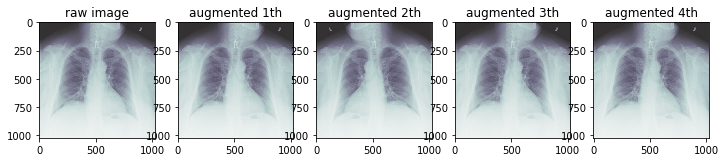

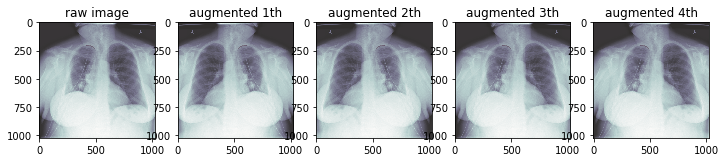

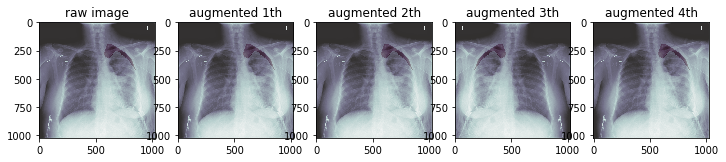

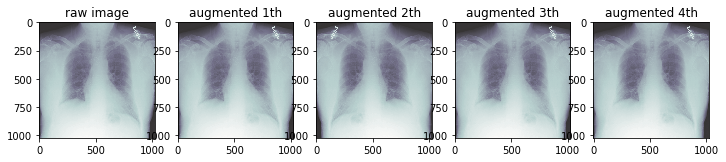

In [107]:
for i in range(4):
    fname = fname_list[i]
    img = plt.imread(fname)
    mask = get_mask(fname)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
    for j,ax in enumerate(axes):
        if j==0:
            t = 'raw image'
        else:
            t = 'augmented %dth'%j
            img, mask = run_augmentation(img, mask)
        ax.imshow(img, cmap=plt.cm.bone)
        ax.imshow(mask, alpha=.2, cmap='Reds')
        ax.set_title(t)

## 增添你认为合适的Image Augment方法，并通过实验验证是否对模型精度有帮助
- 图像变换
- 亮度
- （高斯）模糊
- 剪切粘贴(crop & paste)
- 旋转/翻转
- 透视变换等

In [84]:
def run_augmentation(image, mask):
    #1. flip lr
    if np.random.rand()<0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    #2. 
    pass
    return image, mask

## Mixup实现、可视化

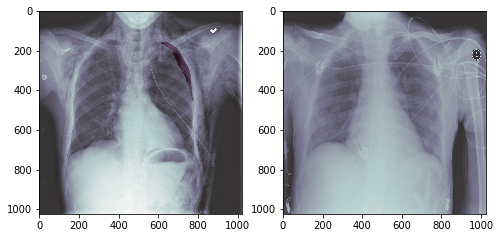

In [116]:
fnames = np.random.choice(fname_list, 2)
img0 = plt.imread(fnames[0])
mask0 = get_mask(fnames[0])
img1 = plt.imread(fnames[1])
mask1 = get_mask(fnames[1])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(img0, cmap=plt.cm.bone)
axes[0].imshow(mask0, alpha=0.2, cmap='Reds')
axes[1].imshow(img1, cmap=plt.cm.bone)
axes[1].imshow(mask1, alpha=0.2, cmap='Reds')

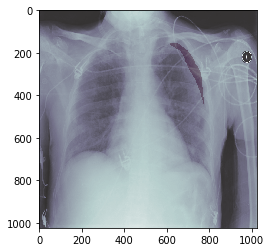

In [193]:
w = 0.1
mixup = img0 * w + img1 * (1 - w)
mixup_mask = mask0 * w + mask1 * (1 - w)

plt.imshow(mixup, cmap=plt.cm.bone)
plt.imshow(mixup_mask, alpha=0.2, cmap='Reds')

In [194]:
mixup_mask.max()

0.1

## 推理阶段使用图像增广，比较对模型预测效果有无区别
- 图像尺寸
- 翻转

In [180]:
from model.model_unet import UNetResNet34
from utils.utils import load_checkpoint

train_dl, val_dl = prepare_trainset(BATCH_SIZE=4, NUM_WORKERS=16, SEED=2019, IMG_SIZE=512, debug=True)

device = 'cuda:0'
net = UNetResNet34(debug=False).cuda(device=device)
checkpoint_path = '../checkpoint/UNetResNet34_512_v1_seed2019/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

Count of trainset (for training):  900
Count of validset (for training):  200


In [181]:
import torch
def predict_proba(net, test_dl, device):
    net.set_mode('valid')
    y_pred = None
    with torch.no_grad():
        for i, (image, masks) in enumerate(test_dl):
            input_data = image.to(device=device, dtype=torch.float)
            logit = torch.sigmoid(net(input_data)).cpu().numpy()
            if y_pred is None:
                y_pred = logit
            else:
                y_pred = np.concatenate([y_pred, logit], axis=0)
    IMG_SIZE = y_pred.shape[-1]
    return y_pred.reshape(-1, IMG_SIZE, IMG_SIZE)

def predict_proba_flip(net, test_dl, device):
    net.set_mode('valid')
    y_pred = None
    with torch.no_grad():
        for i, (image, masks) in enumerate(test_dl):
            input_data = torch.flip(image, [3]).to(device=device, dtype=torch.float)
            logit = torch.sigmoid(net(input_data)).cpu().numpy()[:,:,:,::-1]
            if y_pred is None:
                y_pred = logit
            else:
                y_pred = np.concatenate([y_pred, logit], axis=0)
    IMG_SIZE = y_pred.shape[-1]
    return y_pred.reshape(-1, IMG_SIZE, IMG_SIZE)

In [182]:
preds_valid = predict_proba(net, val_dl, device)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [184]:
preds_valid_flip = predict_proba_flip(net, val_dl, device)

/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/bigdata/data/endi/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


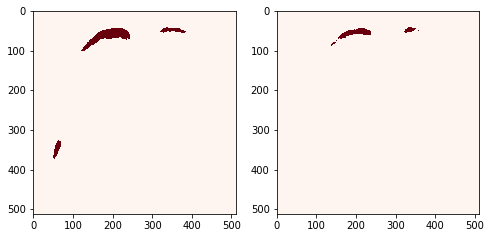

In [192]:
idx = 0

pred_mask, pred_mask_flip = preds_valid[idx], preds_valid_flip[idx]
threshold = 0.2
pred_mask, pred_mask_flip = (pred_mask>threshold).astype(int), (pred_mask_flip>threshold).astype(int)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(pred_mask, cmap='Reds')
axes[1].imshow(pred_mask_flip, cmap='Reds')

## 后处理：利用cv2对模型预测输出mask进行切分

In [12]:
import cv2
cv2.connectedComponents

<function connectedComponents>